In [1]:
cd ..

/Users/flamholz/Documents/workspace/carboxecoli


In [2]:
%matplotlib inline

import cobra
import numpy as np
import escher
import optslope_rubisco
import pandas as pd
import pint
import seaborn as sns

from cobra.core import model
from cobra.flux_analysis import phenotype_phase_plane, pfba, flux_variability_analysis
from cobra.io import read_sbml_model
from cobra.io import sbml
from copy import deepcopy
from importlib_resources import read_text
from matplotlib import pyplot as plt
from typing import List, Tuple, Iterable, Any
from scipy import stats

In [3]:
# Make a color palette for the swarmplot that colors replicates differently.
greys = sns.color_palette('Greys', n_colors=8)
blues = sns.color_palette('Blues', n_colors=8)
greens = sns.color_palette('Greens', n_colors=8)
purples = sns.color_palette('Purples', n_colors=8)
reddish_purple = sns.set_hls_values(sns.xkcd_rgb['reddish purple'], 0.9, 0.3, 1)

In [4]:
# Read in the WT model
#WT_MODEL_FNAME = 'optslope_rubisco/iML1515_with_rpp.xml'
WT_MODEL_FNAME = 'optslope_rubisco/core_model_with_rpp.xml'
wt_model = read_sbml_model(WT_MODEL_FNAME)

# Make a CCMB1 model: WT sans rpi, edd and eda activities
ccmb1_model = read_sbml_model(WT_MODEL_FNAME)
ccmb1_model.reactions.RPI.knock_out()
ccmb1_model.reactions.EDD.knock_out()

# glycerol is converted to DHAP in E. coli
ccmb1_model.exchanges.EX_dhap_e.bounds = (-1000, 1000)

# Second model that disallows overflow metabolism entirely.
# This gives an upper limit of the fraction of 3PG production due to rubisco.
ccmb1_model_no_overflow = read_sbml_model(WT_MODEL_FNAME)
ccmb1_model_no_overflow.reactions.RPI.knock_out()
ccmb1_model_no_overflow.reactions.EDD.knock_out()
ccmb1_model_no_overflow.reactions.EDA.knock_out()

# glycerol is converted to DHAP in E. coli
ccmb1_model_no_overflow.exchanges.EX_dhap_e.bounds = (-1000, 1000)

# Disallow overflow by disabling carbon exchange other than glycerol and CO2.
for ex in ccmb1_model_no_overflow.exchanges:
    # Leave glycerol and CO2 alone
    if ex.id in ('EX_dhap_e', 'EX_co2_e'):
        continue
        
    # Turn off all other carbon exchange
    mb = ex.check_mass_balance()
    if abs(mb.get('C', 0)) >= 1:
        ex.bounds = (0, 0)

In [5]:
# Diagram central metabolic fluxes for a single pFBA prediction for complemented CCMB1 grown on glycerol.
# Need to use the core objective to avoid a number of implausible bypasses and cycles
growth_obj = ccmb1_model.reactions.BIOMASS_Ecoli_core_w_GAM
s_max = pfba(ccmb1_model, fraction_of_optimum=0.9999, objective=growth_obj)
escher.Builder(map_name="e_coli_core.Core metabolism", reaction_data=s_max.fluxes)

Builder(reaction_data={'ACALD': -116.57174016330674, 'ACALDt': -1.3250000000011388, 'ACKr': -156.9210304676978…

In [6]:
# Print exchange fluxes to make sure imports are reasonable.
# Notice that there is substantial secretion of acetate, formate, and ethanol in this example.
# Glycerol is predominantly metabolized aerobically by E. coli and selection for improved glycerol growth 
# tends to increase overflow metabolism (e.g. Cheng et al. Nat. Comm. 2014). For this reason we calculate
# flux predictions below with and without of overflow metabolism in order to get a plausible range. 
print('Growth rate', s_max.objective_value)
exs = ccmb1_model.exchanges
for ex in exs:
    if abs(s_max.fluxes[ex.id]) > 0.1:
        print(ex, s_max.fluxes[ex.id])
        
# Summary of fluxes to/from 3PG helps figure out the directionality.
ccmb1_model.metabolites.get_by_id('3pg_c').summary(s_max.fluxes)

Growth rate 19873.31306018833
EX_ac_e: ac_e -->  156.92103046769782
EX_acald_e: acald_e -->  1.3250000000011388
EX_co2_e: co2_e <=>  664.4976547533506
EX_etoh_e: etoh_e -->  115.2467401633056
EX_h_e: h_e <=>  1000.0
EX_h2o_e: h2o_e <=>  -144.60130646373966
EX_nh4_e: nh4_e <=>  -229.16954162840167
EX_o2_e: o2_e <=>  -500.0
EX_pi_e: pi_e <=>  845.3920934587001
EX_dhap_e: dhap_e <=>  -1000.0


In [7]:
# Growth rate has default constraints because we don't have a measured uptake rate.
growth_obj = ccmb1_model.reactions.BIOMASS_Ecoli_core_w_GAM

# Run pFBA over a range "fraction_of_optimum" values to get a sense of fluxes.
# Here we use default media so overflow production is allowed.
# NOTE: no reason to allow f_opt < 0.8 as it doesn't affect the relative rubisco flux.
f_opt = np.arange(0.8, 0.991, 0.01).tolist() + np.arange(0.991, 1.001, 0.001).tolist()
opt_fluxes_overflow_allowed = []
for frac_of_opt in f_opt:    
    s_max = pfba(ccmb1_model, fraction_of_optimum=frac_of_opt, objective=growth_obj)
    opt_fluxes_overflow_allowed.append(s_max.fluxes)

In [8]:
# Make a single prediction without overflow metabolism.
# NOTE: when overflow is disabled, the rubisco flux fraction is independent of 
# the "fraction_of_optimum" parameter since the system has far fewer free variables,
# so we make only one estimate.
growth_obj = ccmb1_model_no_overflow.reactions.BIOMASS_Ecoli_core_w_GAM
opt_fluxes_no_overflow = []
s_max = pfba(ccmb1_model_no_overflow, fraction_of_optimum=0.99, objective=growth_obj)
opt_fluxes_no_overflow.append(s_max.fluxes)

In [9]:
# Reactions producing/consuming 3-phosphoglycerate in the ECC2+rubisco model
# rubisco (RBC) written in the 3pg producing direction - positive flux = production
# phosphoglycerate mutase (PGM) written in the 3pg producing direction - positive flux = production
# phosphoglycerate kinase (PGK) written in 3pg consuming direction - positive flux = consumption

fba_df = pd.DataFrame(opt_fluxes_overflow_allowed+opt_fluxes_no_overflow)
fba_df['fraction_of_optimum'] = f_opt + [0.99]
fba_df['overflow_allowed'] = [True]*len(f_opt)+[False]
rxns_3pg = 'PGK,RBC,PGM,EX_ac_e,fraction_of_optimum,overflow_allowed'.split(',')

rbc_producing = fba_df.RBC >= 0
pgm_consuming = fba_df.PGM <= 0
pgk_producing = fba_df.PGK <= 0

# Check directional consistency
print('3pg producing reactions')
print('\tRubisco producing 3pg at all growth rates:', rbc_producing.all())
print('\tPGK producing 3pg at all growth rates:', pgk_producing.all())

print()
print('3pg consuming reactions')
print('\tPGM consuming 3pg at all growth rates:', pgm_consuming.all())

# Total 3pg production as a function of growth rate - produced by rubisco and pgk.
# Remember that PGK is written in the 3pg consuming direction, hence negative sign.
total_influx = (2*fba_df.RBC - fba_df.PGK)
flux_to_biomass = total_influx+fba_df.PGM

# total influx and outflux are equal of course. 
rub_pct = 100 * 2*fba_df.RBC / total_influx
pgm_pct = 100 * -fba_df.PGM / total_influx
pgk_pct = 100 * -fba_df.PGK / total_influx
# remaining flux to biomass goes to serine from 3pg
pct_to_ser = 100-pgm_pct

fba_df['rub_pct_3pg_prod'] = rub_pct
fba_df['pgk_pct_3pg_prod'] = pgm_pct
fba_df['pgm_pct_3pg_cons'] = pgm_pct
fba_df['ser_pct_3pg_cons'] = pct_to_ser
rxns_3pg += 'rub_pct_3pg_prod,pgk_pct_3pg_prod,pgm_pct_3pg_cons,ser_pct_3pg_cons'.split(',')

mean_rub_pct = rub_pct.mean()
mean_ser_pct = pct_to_ser.mean()
rub_pct_range = (fba_df.rub_pct_3pg_prod.min(), fba_df.rub_pct_3pg_prod.max())

print()
print('Mean percent of 3PG production flux through rubisco across all estimates: %.1f%%' % mean_rub_pct)
print('\tRange of rubisco percentages: (%.1f%%, %.1f%%)' % rub_pct_range)
print('Mean percent of 3PG consumption flux to serine across all estimates: %.1f%%' % mean_ser_pct)

3pg producing reactions
	Rubisco producing 3pg at all growth rates: True
	PGK producing 3pg at all growth rates: True

3pg consuming reactions
	PGM consuming 3pg at all growth rates: True

Mean percent of 3PG production flux through rubisco across all estimates: 20.7%
	Range of rubisco percentages: (19.5%, 23.9%)
Mean percent of 3PG consumption flux to serine across all estimates: 7.2%


In [10]:
# Load amino acid LCMS data
float_types = ['ser', 'his', 'val', 'thr', 'pro', 'arg', 'glu']
short_names = float_types
long_names = ['Serine', 'Histidine', 'Valine', 'Threonine', 'Proline', 'Arginine', 'Glutamate']
dtypes = dict((aa, pd.np.float64) for aa in float_types)
fname = 'notebooks/data/fig4/022720_repeat_f13c_extracted_transpose.csv'

# Data is the fraction of C atoms that are 13C
frac13c_df = pd.read_csv(fname, index_col=0, na_values='NAN', dtype=dtypes)

# Convert data to fraction 12C from fraction 13C
frac12c_df = frac13c_df.copy()
frac12c_df[float_types] = 1.0 - frac13c_df[float_types]

# Serine and valine are products of lower glycolysis, so they are good
# proxies for 3PG labeling in the control. His is produced from ribose
# with the addition of a single C1 unit (1/6) carbons from THF.
# The remaining measured AAs are in some way connected to the TCA cycle and
# anaplerotic inorganic carbon incorporation, so they are bad proxies for the input carbon. 
representative_aas = ['ser', 'val', 'his']

for aa in representative_aas:
    for sn in ['CAfree_bioreactor', 'CCMB1_bioreactor']:
        mask = frac12c_df.sample_name == sn
        vals = frac12c_df[mask][aa].values
        
        # Drop zeros
        pct_vals = vals[vals>0]*100
        mean_std_12c = np.mean(pct_vals), np.std(pct_vals)
        print(sn, aa, 'mean 12C labeling: %.2f%% +/- %.1f%%' % mean_std_12c)
    print()
    
frac12c_df[frac12c_df.sample_name.isin(['CAfree_bioreactor', 'CCMB1_bioreactor'])][['ser', 'sample_name']]

CAfree_bioreactor ser mean 12C labeling: 0.62% +/- 0.2%
CCMB1_bioreactor ser mean 12C labeling: 3.49% +/- 2.2%

CAfree_bioreactor val mean 12C labeling: 0.60% +/- 0.1%
CCMB1_bioreactor val mean 12C labeling: 1.67% +/- 0.7%

CAfree_bioreactor his mean 12C labeling: 0.70% +/- 0.1%
CCMB1_bioreactor his mean 12C labeling: 0.85% +/- 0.4%



/Users/flamholz/Library/Python/3.6/lib/python/site-packages/ipykernel_launcher.py:5 FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead


,ser,sample_name
sample,,
AF 1,0.004527,CAfree_bioreactor
AF 2,0.008998,CAfree_bioreactor
AF 3,0.003495,CAfree_bioreactor
AF 4,0.007835,CAfree_bioreactor
AF 5,0.024767,CCMB1_bioreactor
AF 6,0.028638,CCMB1_bioreactor
AF 7,0.072608,CCMB1_bioreactor
AF 8,0.013666,CCMB1_bioreactor


In [11]:
# LCMS calculations 

# Calculate the intracellular 13C and 12C fractions by comparing arginine with glutamate and proline.
# Gleizer et al. Cell 2019 average inferences from glu and pro comparisons (to arg). However the
# proline comparison gives a negative value for sample 7 so it has to be left out here. 
f13c_cyto_glu = 6 * frac13c_df.arg - 5 * frac13c_df.glu
f13c_cyto_pro = 6 * frac13c_df.arg - 5 * frac13c_df.pro

# handy summary dataframe for checking the calculation
df_data = {'sample_name': frac13c_df.sample_name, 'f13c_cyto_glu': f13c_cyto_glu, 'f13c_cyto_pro': f13c_cyto_pro}
cyto_ci_isotopes_df = pd.DataFrame(df_data)
cyto_ci_isotopes_df['mean_f13c_cyto'] = cyto_ci_isotopes_df['f13c_cyto_glu']
cyto_ci_isotopes_df['f12c_cyto_inferred'] = 1.0 - cyto_ci_isotopes_df.mean_f13c_cyto
cyto_ci_isotopes_df['pct12c_cyto_inferred'] = 100*cyto_ci_isotopes_df.f12c_cyto_inferred

# Calculate the mean f12c for the controls for reporting in the text
mean_isotope_df = cyto_ci_isotopes_df.groupby('sample_name').mean()
std_isotope_df = cyto_ci_isotopes_df.groupby('sample_name').std()

mean_control_f12c_cyto = mean_isotope_df.loc['CAfree_bioreactor'].f12c_cyto_inferred
std_control_f12c_cyto = std_isotope_df.loc['CAfree_bioreactor'].f12c_cyto_inferred

mean_exp_f12c_cyto = mean_isotope_df.loc['CCMB1_bioreactor'].f12c_cyto_inferred
std_exp_f12c_cyto = std_isotope_df.loc['CCMB1_bioreactor'].f12c_cyto_inferred

print('Average control has %.1f%% +/- %.1f%% 12C in the cytosol' % (
    100*mean_control_f12c_cyto, 100*std_control_f12c_cyto))
print('Average experiment has %.1f%% +/- %.1f%% 12C in the cytosol' % (
    100*mean_exp_f12c_cyto, 100*std_exp_f12c_cyto))

# Now we ask: what fraction of that 12C makes it onto serine in the control. 
mean_AA_labeling_df = frac12c_df.groupby('sample_name').mean()
mean_control_f12c_ser = mean_AA_labeling_df.loc['CAfree_bioreactor'].ser
baseline_12c_cycling_ser = mean_control_f12c_cyto / mean_control_f12c_ser
print('Control has an average of %.1f%% 12C on serine' % (100*mean_control_f12c_ser))
print('This is 1/%.1f of the cytosolic 12C pool' % (baseline_12c_cycling_ser))

# Now we infer the fraction of 3pg production flux that is due to rubisco.
# Assumptions:
# 1. DHAP has ≈0.6% 12C labeling in both exp and control.
#    a. Same becuse it is a direct product of glycerol
#    b. 0.6% estimated from the labeling of serine and valine in the control.
# 2. RuBP has ≈0.6% 12C labeling in the experiment
#       estimated from serine, valine and histidine in the control.
# 3. Rubisco carboxylates from a pool with the 12C composition calculated from arg/glu comparison above. 
#       This fraction is inferred on a per-sample basis. 
f12c_dhap_assumed = mean_control_f12c_ser   # exp and control, assumed 0.6% see above
f12c_rubp_assumed = f12c_dhap_assumed       # only exp makes rubp
rel_rub_flux = frac12c_df.ser - f12c_dhap_assumed
rel_rub_flux /= (((f12c_dhap_assumed * 5 + cyto_ci_isotopes_df.f12c_cyto_inferred)/6)
                 - f12c_dhap_assumed)
mean_rub_3pg_production = rel_rub_flux[frac12c_df.sample_name == 'CCMB1_bioreactor'].mean()
print()
print('Mean inferred 3pg production flux fraction due to rubisco: %.1f%%' % (
    mean_rub_3pg_production*100))
rel_rub_flux[frac12c_df.sample_name == 'CCMB1_bioreactor']

Average control has 25.0% +/- 3.9% 12C in the cytosol
Average experiment has 66.8% +/- 27.8% 12C in the cytosol
Control has an average of 0.6% 12C on serine
This is 1/40.3 of the cytosolic 12C pool

Mean inferred 3pg production flux fraction due to rubisco: 24.2%


sample
AF 5    0.276332
AF 6    0.149038
AF 7    0.441850
AF 8    0.101784
Name: ser, dtype: float64

In [27]:
control_f12ser = frac12c_df[frac12c_df.sample_name == 'CAfree_bioreactor'].ser.values
exp_f12ser = frac12c_df[frac12c_df.sample_name == 'CCMB1_bioreactor'].ser.values
f12co2_exp = cyto_ci_isotopes_df[cyto_ci_isotopes_df.sample_name == 'CCMB1_bioreactor'].f12c_cyto_inferred.values
shape = (int(1e5), 4)

# Assume f12 for DHAP follows distribution observed for serine in the control
f12c_dhap_samples = np.random.normal(loc=0.0062, scale=0.002, size=shape)

# RuBP and DHAP were assumed to have the same f12C. 
# Pessimistically assume that they are independent but have the same mean/stddev
# This will create more variation than setting them to the same values
f12c_rubp_exp_samples = np.random.normal(loc=0.0062, scale=0.001, size=shape)

# Using estimated f12co2 and f12ser distributions from the same experimental sample, as our
# model and basic intuition says they must be correlated (rubisco fixes CO2 into serine). 
# f12ser is a direct LC-MS measurement: assume 0.1% error 
f12c_ser_exp_samples = np.random.normal(loc=exp_f12ser, scale=0.001, size=shape)

# f12co2 is indirectly inferred from glutamate and arginine, assume larger 1% error.
f12co2_exp_samples = np.random.normal(loc=f12co2_exp, scale=0.05, size=shape)

rel_rub_flux_samples = f12c_ser_exp_samples -  f12c_dhap_samples
rel_rub_flux_samples /= (((f12c_dhap_samples*5 + f12co2_exp_samples)/6) - f12c_dhap_samples)
pct_rub_flux_samples = rel_rub_flux_samples*100

Inference of plausible range for rubisco fraction of 3PG production flux
Overall median: 19.1%
	 99% CI: 3.9-50.7%

Per-sample inference of rubisco flux range
Sample 0 median: 27.7%
	 99% CI: 17.6-43.7%
Sample 1 median: 14.9%
	 99% CI: 10.8-19.6%
Sample 2 median: 44.2%
	 99% CI: 37.6-52.5%
Sample 3 median: 10.2%
	 99% CI: 2.4-19.8%


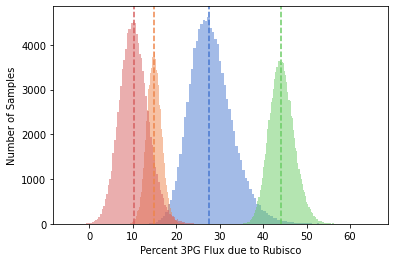

In [28]:
# Plot sampled distributions of rubisco flux for all four experimental samples.
plt.figure()
print('Inference of plausible range for rubisco fraction of 3PG production flux')
low, med, high = np.percentile(pct_rub_flux_samples.flatten(), [0.5, 50, 99.5])
print('Overall median: %.1f%%' % med)
print('\t 99%% CI: %.1f-%.1f%%' % (low, high))
print()
print('Per-sample inference of rubisco flux range')
pal = sns.color_palette('muted')
for c in range(4):
    plt.hist(pct_rub_flux_samples[:, c], bins=100, alpha=0.5, color=pal[c])
    low, med, high = np.percentile(pct_rub_flux_samples[:, c], [0.5, 50, 99.5])
    plt.axvline(med, ls='--', color=pal[c])
    print('Sample %d median: %.1f%%' % (c, med))
    print('\t 99%% CI: %.1f-%.1f%%' % (low, high))
    
plt.xlabel('Percent 3PG Flux due to Rubisco')
plt.ylabel('Number of Samples')
plt.show()

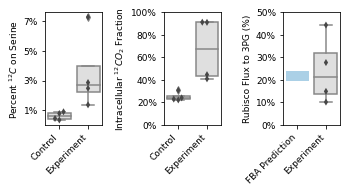

In [14]:
fig = plt.figure(figsize=(7.25, 2.75))
gs = fig.add_gridspec(1, 4, width_ratios=[2.5, 1, 1, 1])

# plot %12C on serine
ax0 = plt.subplot(gs[0, 1])
pct12c_df = frac12c_df.copy()
pct12c_df[pct12c_df.columns[:-2]] *= 100
sns.boxplot(data=pct12c_df, x='sample_name', y='ser', order=['CAfree_bioreactor', 'CCMB1_bioreactor'], ax=ax0, color=greys[1])
sns.swarmplot(data=pct12c_df, x='sample_name', y='ser', order=['CAfree_bioreactor', 'CCMB1_bioreactor'], ax=ax0, color=greys[-2], marker='d')

yticks = np.arange(1, 7.1, 2)
plt.yticks(yticks, ['%d%%' % y for y in yticks], fontsize=9)
plt.xticks([0, 1],[ 'Control', 'Experiment'], fontsize=9, rotation=45, ha='right')
ax0.set_ylabel('Percent $^{12}C$ on Serine', fontsize=9)
ax0.set_xlabel('')

# plot inferred 12Ci fraction.
ax1 = plt.subplot(gs[0, 2])
sns.boxplot(data=cyto_ci_isotopes_df, x='sample_name', y='pct12c_cyto_inferred', order=['CAfree_bioreactor', 'CCMB1_bioreactor'], ax=ax1, color=greys[1])
sns.swarmplot(data=cyto_ci_isotopes_df, x='sample_name', y='pct12c_cyto_inferred', order=['CAfree_bioreactor', 'CCMB1_bioreactor'], ax=ax1, color=greys[-2], marker='d')

yticks = np.arange(0, 101, 20)
plt.yticks(yticks, ['%d%%' % y for y in yticks], fontsize=9)
plt.xticks([0, 1], ['Control', 'Experiment'], fontsize=9, rotation=45, ha='right')
ax1.set_xlabel('')
ax1.set_ylabel('Intracellular $^{12}CO_2$ Fraction', fontsize=9)


# Estimated flux through rubisco as compared to FBA predictions
ax2 = plt.subplot(gs[0, 3])

inferred_rub_flux = (rel_rub_flux[frac12c_df.sample_name == 'CCMB1_bioreactor']*100).values.tolist()
n_exps = len(inferred_rub_flux)

# TODO - actually use prediction here.
width = 0.8
xy = (-width/2, rub_pct_range[0])
height = rub_pct_range[1] - rub_pct_range[0]
fba_rect = plt.Rectangle(xy, width, height, facecolor=blues[2])
ax2.add_patch(fba_rect)


sns.boxplot(x=[1]*n_exps, y=inferred_rub_flux, order=[0, 1], ax=ax2, color=greys[1])
sns.swarmplot(x=[1]*n_exps, y=inferred_rub_flux, order=[0, 1], ax=ax2, color=greys[-2], marker='d')

#plt.scatter([1]*n_exps, inferred_rub_flux, marker='d', s=12, color=greys[-2])
#sns.swarmplot(x=[1]*4, y=inferred_rub_flux, ax=ax2, color=greys[-2], marker='d')

yticks = np.arange(0, 51, 10)
plt.yticks(yticks, ['%d%%' % y for y in yticks], fontsize=9)
plt.xticks([0, 1],['FBA Prediction', 'Experiment'], fontsize=9, rotation=45, ha='right')
ax2.set_ylabel('Rubisco Flux to 3PG (%)', fontsize=9)
ax2.set_xlabel('')
ax2.set_ylim(0, 50)
ax2.set_xlim(-0.5, 1.5)

plt.tight_layout()
plt.savefig('notebooks/figS8/figS8.png', dpi=300)
plt.show()